In [1]:
import numpy as np
import pandas as pd


In [45]:
class MultiClassLogisticRegression():
    def __init__(self,n_features,n_classes ,learning_rate=0.1, n_iters=1000):
        """
            Z = XW + b
            where:
            - X: input matrix (m x n)
            - W: weights matrix (n x K)
            - b: bias vector (1 x K)

            also:
            - m: number of observations
            - n: number of features
            - K: number of classes 
        """
        self.lr = learning_rate
        self.epochs = n_iters
        self.W1 = np.random.randn(n_features,128) * np.sqrt(2.0 / n_features)
        self.b1 = np.zeros((1,128))
        self.W2 = np.random.randn(128,n_classes) * np.sqrt(2.0 / 128)
        self.b2 = np.zeros((1,n_classes))
        self.h1 = None
        self.Z1 = None

    def ReLU(self,x:np.ndarray) -> np.ndarray:
        return np.maximum(0,x)
    
    def softmax(self,Z: np.ndarray) -> np.ndarray:
        exp_Z = np.exp(Z - np.max(Z,axis=1,keepdims=True))
        P = exp_Z / np.sum(exp_Z, axis=1,keepdims=True)
        return P
    
    def cross_entropy_loss(self,y_pred:np.ndarray,y_true:np.ndarray) -> float:
        """
        Oblicza średnią Stratę Entropii Krzyżowej (Categorical Cross-Entropy Loss).
        L = - (1/m) * SUM( y_true * log(y_pred) )
        """
        m = y_true.shape[0]

        y_pred_clipped = np.clip(y_pred,1e-12,1.0)
        sample_loss = -np.sum(y_true * np.log(y_pred_clipped), axis=1)
        return np.mean(sample_loss)

    
    def forward(self,X:np.ndarray):
        """
            Calculations:
                Z1 = X * W1 + b1
                H1 = max(0,Z1)
                Z2 = H1 * W2 + b2
                Pi = e^(Z2) / SUM(e^(Z2))
        """

        Z1 = X @ self.W1 + self.b1
        self.Z1 = Z1
        h1 = self.ReLU(Z1)
        self.h1 = h1
        Z2 = h1 @ self.W2 + self.b2
        P = self.softmax(Z2)
        return P 
    
    def backward(self,X:np.ndarray,Loss:np.ndarray):
        """
            Example:
                L - loss/error
                We want to calculate dL/dW12 ( How change in W1 will impact on L)
                dL/dW12 = dZ1/dW12 * dH1/dZ1 * dZ2/dH1 * dPi/dZ2 * dL/dPi
                Remember the equations from the forward method
                dL/dW12 = X1 * (derivative of Relu) * (W2)
        """
        m = X.shape[0] # nr_observations
        # dL/dZ2 = P - Y 
        dZ2 = Loss
        dW2 = self.h1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True)/m
        
        dH1 = dZ2 @ self.W2.T
        dReLU = (self.Z1 > 0).astype(float)
        dZ1 = dH1 * dReLU
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True)/m

        # Update params
        self.W2 = self.W2 - self.lr * dW2
        self.b2 = self.b2 - self.lr * db2
        
        self.W1 = self.W1 - self.lr * dW1
        self.b1 = self.b1 - self.lr * db1

    def fit(self,X,y):
        for epoch in range(self.epochs):
            y_pred = self.forward(X)

            loss_gradient = y_pred - y

            loss = self.cross_entropy_loss(y_pred,y)

            self.backward(X,loss_gradient)

            if epoch % 100 == 0:
                print(f"Epoch: {epoch} | Loss: {loss}")

    def predict(self,X_test):
        return self.forward(X_test)







        


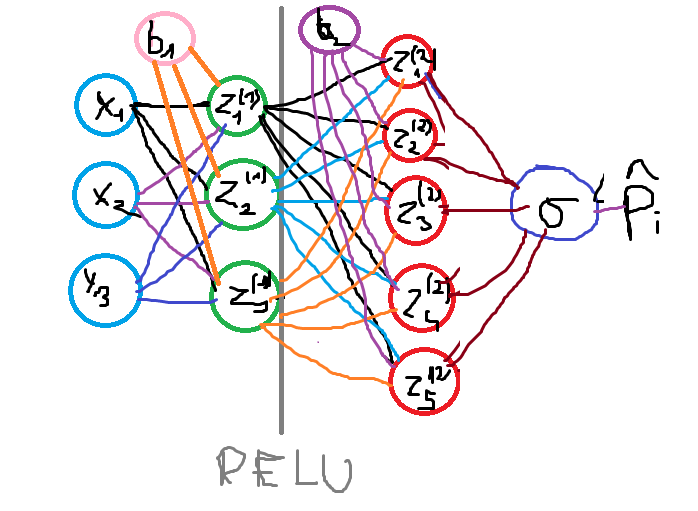

In [2]:
import torch
from torchvision import datasets

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True
)





In [3]:
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

In [4]:
print(X_train.shape)

(60000, 28, 28)


In [49]:
X_train = X_train.astype("float32") / 255.0
X_train = X_train.reshape(-1,28*28)
X_train.shape

(60000, 784)

In [50]:
Y_train_one_hot = np.eye(10)[y_train]

In [51]:
Y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [52]:
model = MultiClassLogisticRegression(n_features=X_train.shape[1],n_classes=10)

In [53]:
model.fit(X_train,Y_train_one_hot)

Epoch: 0 | Loss: 2.398575191737062
Epoch: 100 | Loss: 0.46455458892938817
Epoch: 200 | Loss: 0.3672457919023395
Epoch: 300 | Loss: 0.32759522961272275
Epoch: 400 | Loss: 0.3029106182922128
Epoch: 500 | Loss: 0.28438139745639984
Epoch: 600 | Loss: 0.26911475885270075
Epoch: 700 | Loss: 0.2559433596611479
Epoch: 800 | Loss: 0.2442823929655155
Epoch: 900 | Loss: 0.23365267447260196


In [54]:
X_test = X_test.reshape(-1,28*28) / 255
yhat = model.predict(X_test)

In [55]:
from sklearn import metrics
import matplotlib.pyplot as plt

yhat_labels = np.argmax(yhat,axis=1)

confusion_matrix = metrics.confusion_matrix(y_test,yhat_labels)

plt.show()

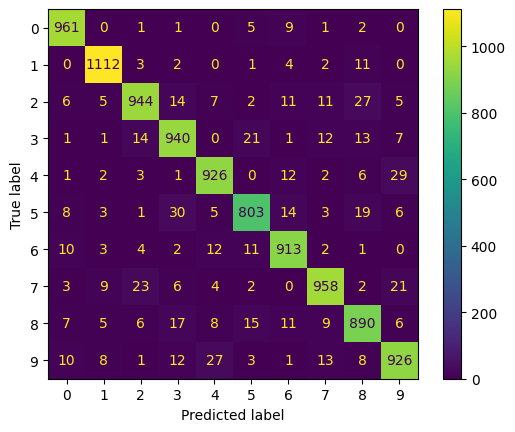

In [56]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

cm_display.plot()
plt.show()

In [58]:
X_test[2],y_test[2]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [60]:
np.argmax(model.predict(X_test[2]))

1

In [63]:
accuracy = metrics.accuracy_score(y_test,yhat_labels)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 93.73%


In [1]:
import cv2
import numpy as np

def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))

    return descriptor